# Boxplots Script

Emily Luschen, Emily.W.Luschen-1@ou.edu \
James Ruppert, jruppert@ou.edu \
12/27/2023

In [1]:
# import packages
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
import master_functions as mf
import seaborn as sns

### Run these cells for all plots

In [2]:
# function for calculating MSE
def calc_mse_budget(mse, lw_net, lw_net_cs):
    # Remove means
    mse_mean   = np.nanmean(mse, axis=(2,3))
    lw_mean    = np.nanmean(lw_net, axis=(2,3))
    lw_mean_cs = np.nanmean(lw_net_cs, axis=(2,3))
    mse_p   = mse -       mse_mean[:, :, np.newaxis, np.newaxis]
    lw_p    = lw_net -    lw_mean[:, :, np.newaxis, np.newaxis]
    lw_p_cs = lw_net_cs - lw_mean_cs[:, :, np.newaxis, np.newaxis]

    # Calculate covariance
    lwmse = mse_p*lw_p # J/m2 * J/m2/s = (J/m2)^2 / s
    msevar = np.nanvar(mse, axis=(2,3)) # (J/m2)^2
    lwmse /= msevar[:, :, np.newaxis, np.newaxis] # units = /s
    lwmse *= 3600*24 # /s --> /day

    # Clear-sky
    lwmse_cs = mse_p*lw_p_cs # J/m2 * J/m2/s = (J/m2)^2 / s
    lwmse_cs /= msevar[:, :, np.newaxis, np.newaxis] # units = /s
    lwmse_cs *= 3600*24 # s/day * /s = /day

    return lwmse, lwmse_cs, msevar

In [3]:
nmem = 10
istorm = 'haiyan'
# istorm = 'maria'
membs = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

In [4]:
ncfile = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/cloud_class/precip_class_ctl.nc' #haiyan
# ncfile = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/cloud_class/precip_class_ctl_maria.nc' #maria

with Dataset(ncfile, 'r') as nc:
    c_type = nc.variables['type'][:,:,:,:] # memb x time x lat x lon

In [5]:
# load in mse, lw_net, and lw_net clear sky
mse = np.zeros((nmem, 97, 740, 1200))
lw_net = np.zeros((nmem, 97, 740, 1200))
lw_net_cs = np.zeros((nmem, 97, 740, 1200))

for c in range(nmem):
    mse_file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/'+istorm+'/memb_'+membs[c]+'/ctl/post/d02/mse_diag.nc'
    mse[c] = mf.var_read(mse_file, 'mse_vint')
    lw_file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/'+istorm+'/memb_'+membs[c]+'/ctl/post/d02/LWnet.nc'
    lw_net[c] = mf.var_read(lw_file, 'LWUPB')
    lwc_file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/'+istorm+'/memb_'+membs[c]+'/ctl/post/d02/LWnetC.nc'
    lw_net_cs[c] = mf.var_read(lwc_file, 'LWUPBC')

    print(c+1)

mse = mf.mask_edges(mse)
lw_net = mf.mask_edges(lw_net)
lw_net_cs = mf.mask_edges(lw_net_cs)

# print(mse[0,0,0,0])

1
2
3
4
5
6
7
8
9
10


In [6]:
# mask out first 12 hours
mse[:,:12,:,:] = np.ma.masked
lw_net[:,:12,:,:] = np.ma.masked
lw_net_cs[:,:12,:,:] = np.ma.masked

# # mask out everything but first 24 hours [comment if doing all time]
# mse[:,36:,:,:] = np.ma.masked
# lw_net[:,36:,:,:] = np.ma.masked
# lw_net_cs[:,36:,:,:] = np.ma.masked

### Run For MSE Plots ONLY

In [7]:
# calculate lw mse terms
lwmse, lwmse_cs, msevar = calc_mse_budget(mse, lw_net, lw_net_cs)
print(lwmse.shape)
print(msevar.shape)

(10, 97, 740, 1200)
(10, 97)


In [8]:
# mask for cloud type
lwmse_dc = np.ma.masked_where((c_type != 1), lwmse, copy=True) # deep convective
lwmse_con = np.ma.masked_where((c_type != 2), lwmse, copy=True) # congestus
lwmse_sc = np.ma.masked_where((c_type != 3), lwmse, copy=True) # shallow convective
lwmse_strat = np.ma.masked_where((c_type != 4), lwmse, copy=True) # stratiform
lwmse_a = np.ma.masked_where((c_type != 5), lwmse, copy=True) # anvil

In [9]:
# average over space
avg_dc = np.nanmean(lwmse_dc, axis=(2,3))
avg_con = np.nanmean(lwmse_con, axis=(2,3))
avg_sc = np.nanmean(lwmse_sc, axis=(2,3))
avg_strat = np.nanmean(lwmse_strat, axis=(2,3))
avg_a = np.nanmean(lwmse_a, axis=(2,3))

In [10]:
# reshape mem x time to 1D array
M,T = avg_strat.shape
plt_dc = np.reshape(avg_dc, M*T)
plt_con = np.reshape(avg_con, M*T)
plt_sc = np.reshape(avg_sc, M*T)
plt_strat = np.reshape(avg_strat, M*T)
plt_a = np.reshape(avg_a, M*T)

In [ ]:
print(np.min(plt_strat))
print(np.max(plt_strat))
print(np.nanmean(plt_strat))

In [11]:
# universal plotting parameters

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

In [12]:
c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']

Text(0.5, 1.0, "d) Class Averaged $ \\mathbf{\\hat{h}' NETLW'}$ 24 hours")

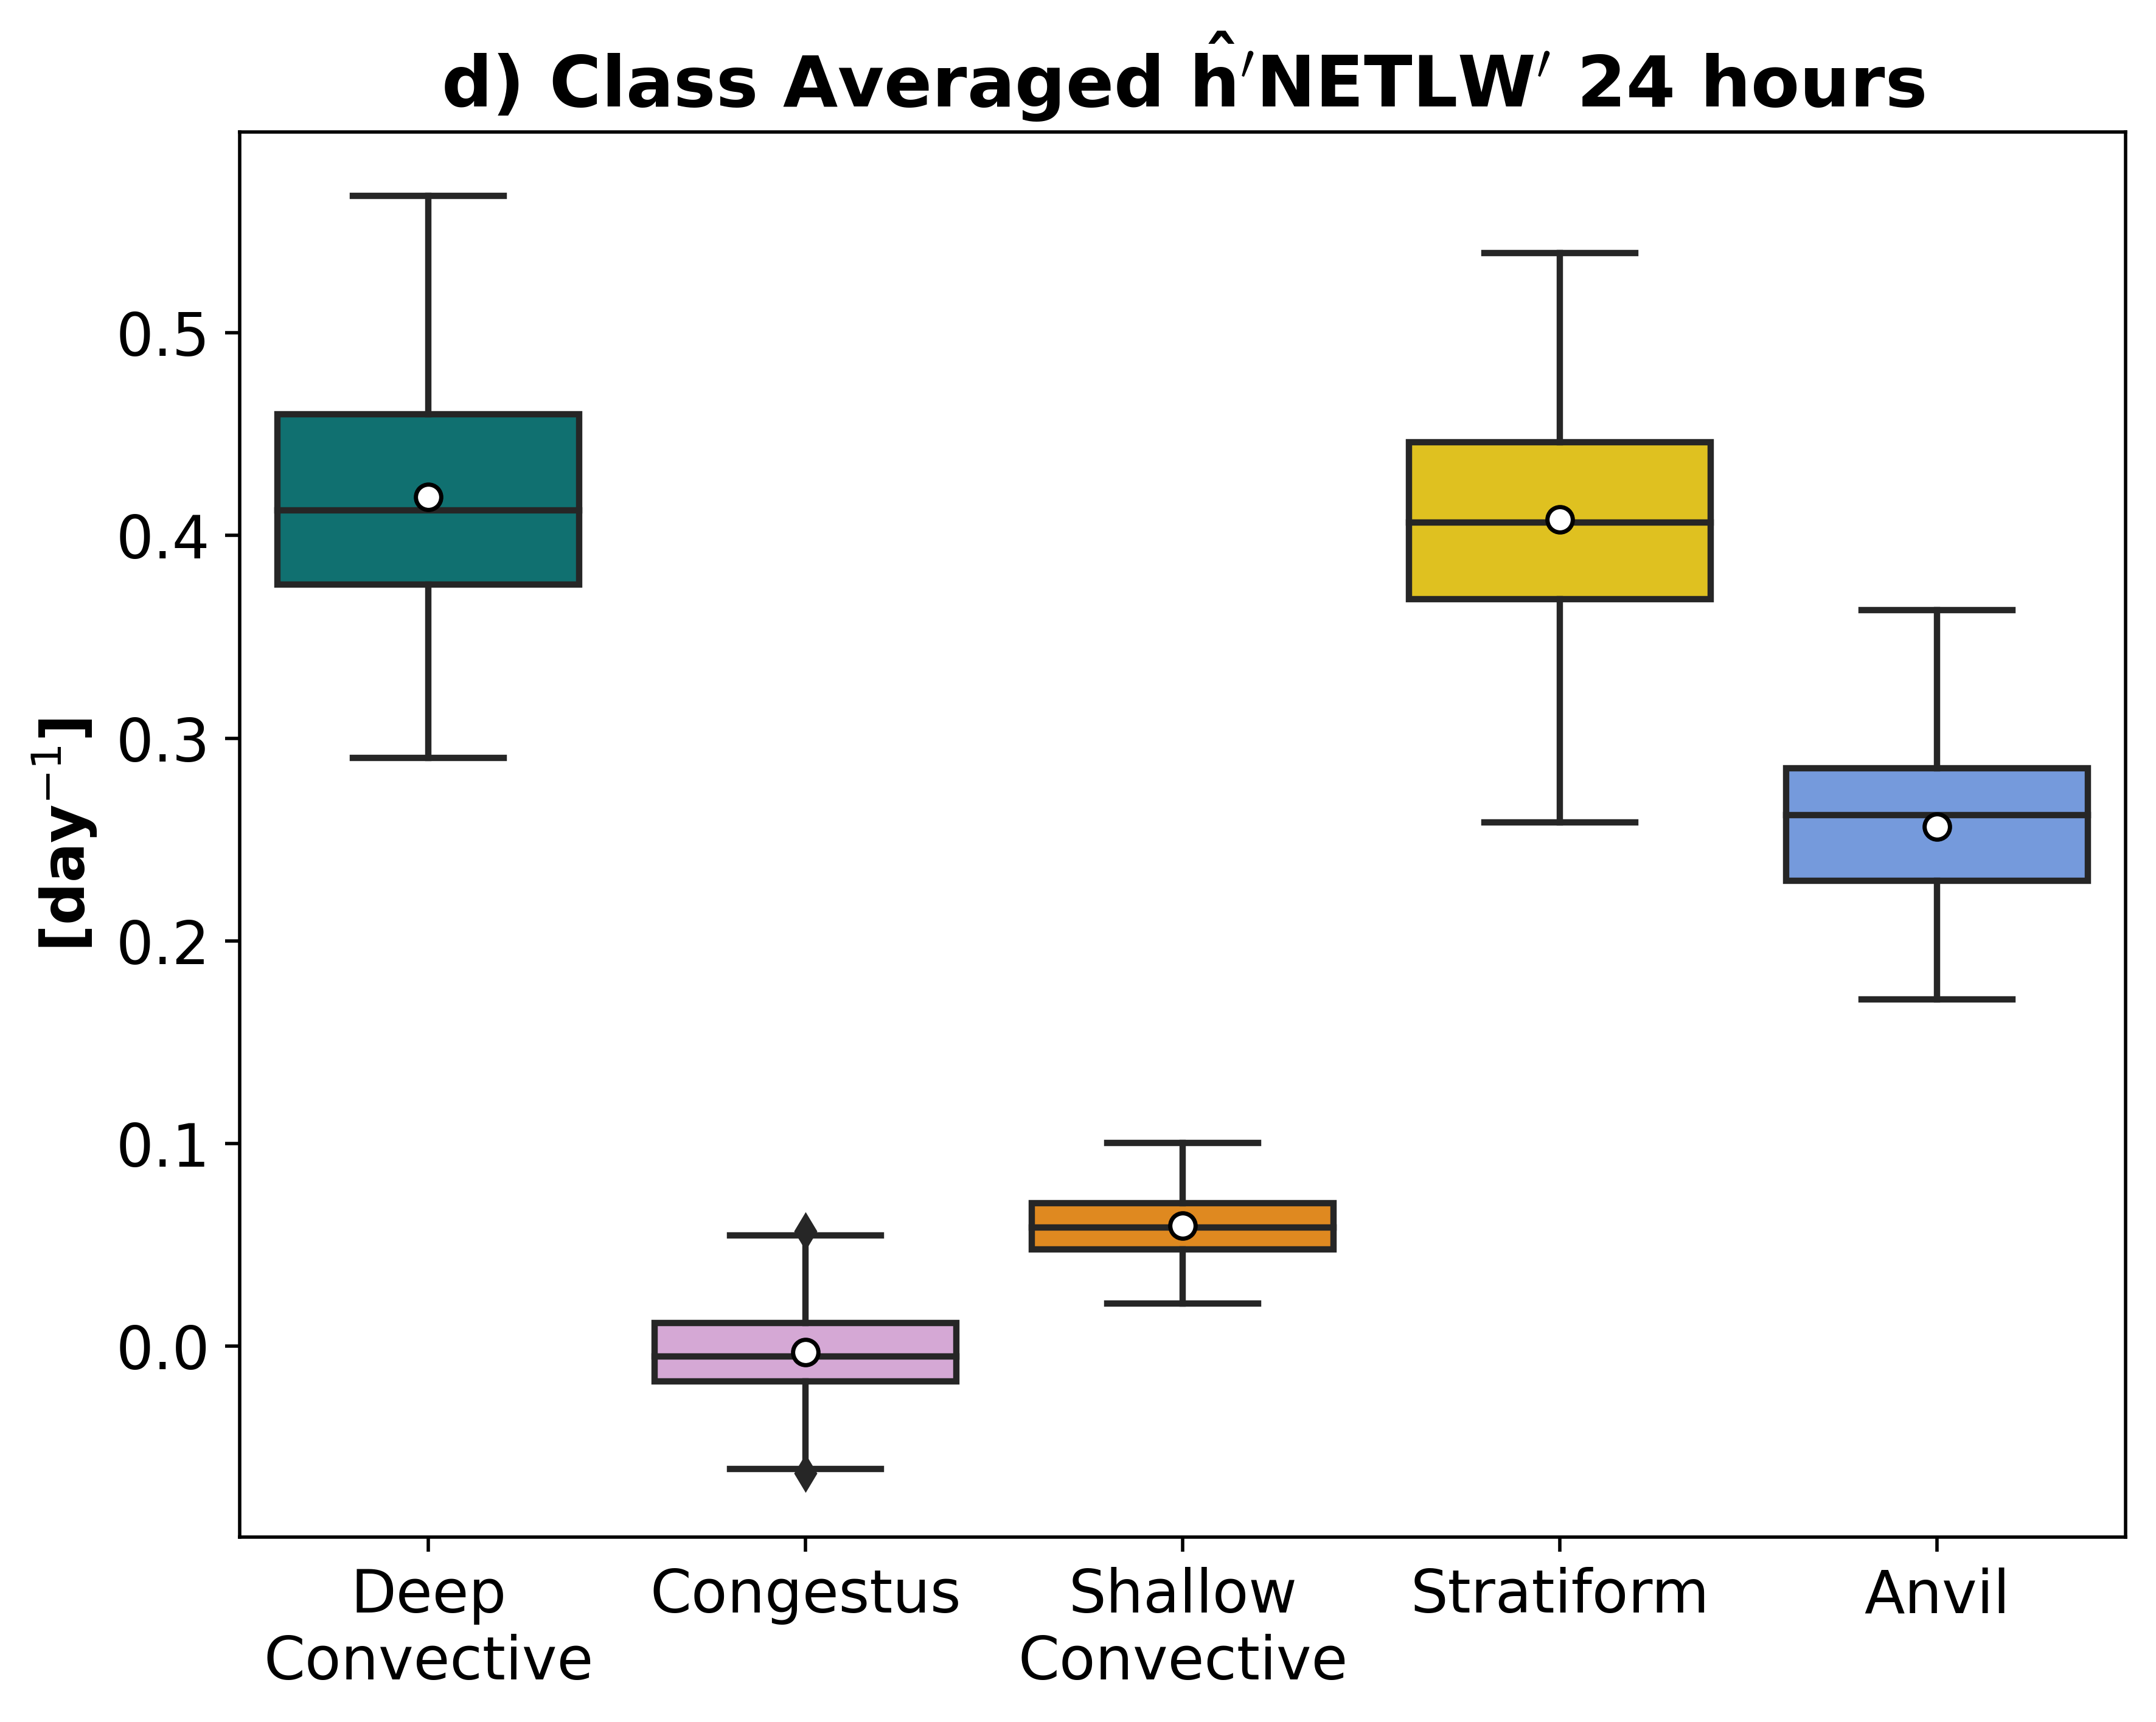

In [13]:
# plot class average
cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
sns.set_palette(cmap)

fig = plt.figure(figsize=(8,6),dpi=500)
fig.set_facecolor('white')
ax = fig.subplots(nrows=1, ncols=1)
sns.boxplot([plt_dc,plt_con,plt_sc,plt_strat,plt_a], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})
ax.set_xticklabels(c_name)
plt.ylabel('[day$^{-1}$]', weight='bold')
plt.title("d) Class Averaged $ \mathbf{\hat{h}' NETLW'}$", weight='bold') # all time
# plt.title("d) Class Averaged $ \mathbf{\hat{h}' NETLW'}$ 24 hours", weight='bold') # 24 hours

#### Domain averaged MSE plot

In [14]:
# count number of unmasked cells
pts_domain = np.ma.MaskedArray.count(lwmse, axis=(2,3))
pts_dc = np.ma.MaskedArray.count(lwmse_dc, axis=(2,3))
pts_con = np.ma.MaskedArray.count(lwmse_con, axis=(2,3))
pts_sc = np.ma.MaskedArray.count(lwmse_sc, axis=(2,3))
pts_strat = np.ma.MaskedArray.count(lwmse_strat, axis=(2,3))
pts_a = np.ma.MaskedArray.count(lwmse_a, axis=(2,3))

# calculate multiplication factor
alpha_dc = pts_dc/pts_domain
alpha_con = pts_con/pts_domain
alpha_sc = pts_sc/pts_domain
alpha_strat = pts_strat/pts_domain
alpha_a = pts_a/pts_domain

/tmp/ipykernel_44632/2208442846.py:10: RuntimeWarning: invalid value encountered in true_divide
  alpha_dc = pts_dc/pts_domain
/tmp/ipykernel_44632/2208442846.py:11: RuntimeWarning: invalid value encountered in true_divide
  alpha_con = pts_con/pts_domain
/tmp/ipykernel_44632/2208442846.py:12: RuntimeWarning: invalid value encountered in true_divide
  alpha_sc = pts_sc/pts_domain
/tmp/ipykernel_44632/2208442846.py:13: RuntimeWarning: invalid value encountered in true_divide
  alpha_strat = pts_strat/pts_domain
/tmp/ipykernel_44632/2208442846.py:14: RuntimeWarning: invalid value encountered in true_divide
  alpha_a = pts_a/pts_domain


In [15]:
# Domain avg averages
dom_avg_dc = avg_dc * alpha_dc
dom_avg_con = avg_con * alpha_con
dom_avg_sc = avg_sc * alpha_sc
dom_avg_strat = avg_strat * alpha_strat
dom_avg_a = avg_a * alpha_a

In [16]:
# reshape mem x time to 1D
M,T = dom_avg_strat.shape
dom_plt_dc = np.reshape(dom_avg_dc, M*T)
dom_plt_con = np.reshape(dom_avg_con, M*T)
dom_plt_sc = np.reshape(dom_avg_sc, M*T)
dom_plt_strat = np.reshape(dom_avg_strat, M*T)
dom_plt_a = np.reshape(dom_avg_a, M*T)

Text(0.5, 1.0, "c) Domain Averaged $ \\mathbf{\\hat{h}' NETLW'}$ 24 hours")

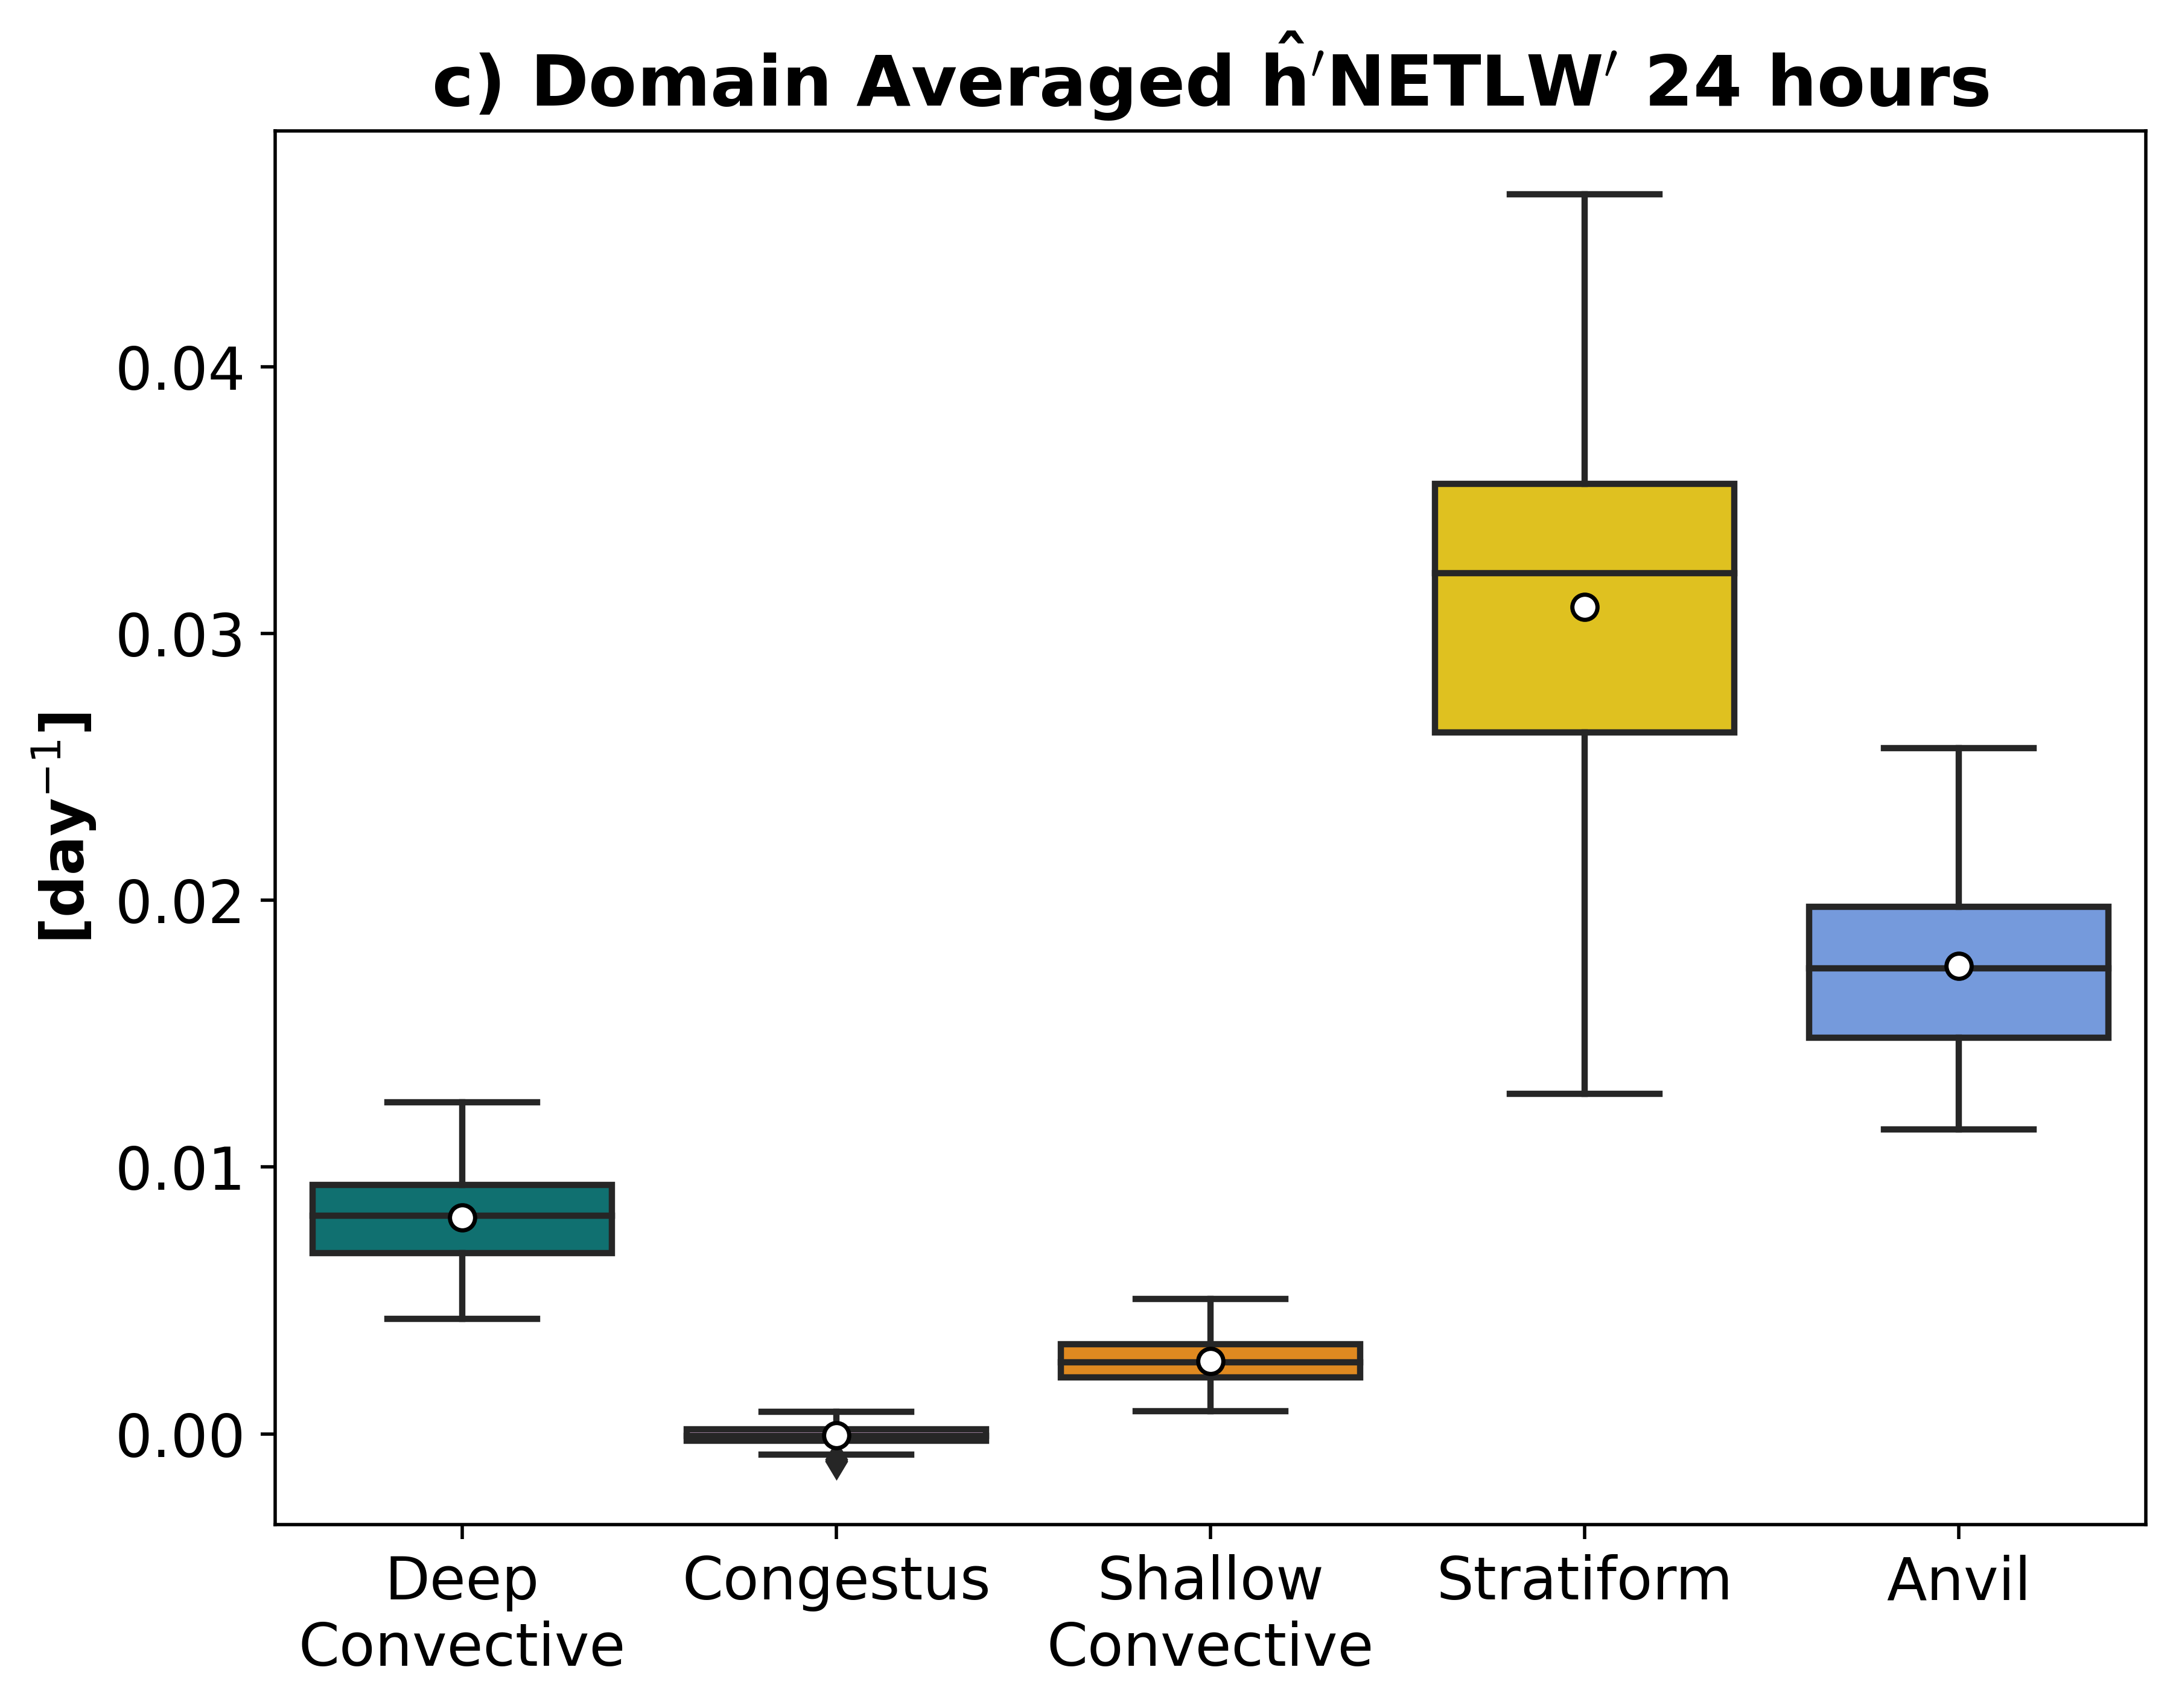

In [17]:
cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
sns.set_palette(cmap)

fig = plt.figure(figsize=(8,6),dpi=500)
fig.set_facecolor('white')
ax = fig.subplots(nrows=1, ncols=1)
sns.boxplot([dom_plt_dc,dom_plt_con,dom_plt_sc,dom_plt_strat,dom_plt_a], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})
ax.set_xticklabels(c_name)
plt.ylabel('[day$^{-1}$]', weight='bold')
plt.title("c) Domain Averaged $ \mathbf{\hat{h}' NETLW'}$", weight='bold') # all time
# plt.title("c) Domain Averaged $ \mathbf{\hat{h}' NETLW'}$ 24 hours", weight='bold') # 24 hours

## LW ACRE
#### Restart kernel and run first few cells before skipping down here

In [ ]:
# Calculate LWACRE by cloud type
lwacre = lw_net - lw_net_cs

lwacre_dc = np.ma.masked_where((c_type != 1), lwacre, copy=True) # deep convective
lwacre_con = np.ma.masked_where((c_type != 2), lwacre, copy=True) # congestus
lwacre_sc = np.ma.masked_where((c_type != 3), lwacre, copy=True) # shallow convective
lwacre_strat = np.ma.masked_where((c_type != 4), lwacre, copy=True) # stratiform
lwacre_a = np.ma.masked_where((c_type != 5), lwacre, copy=True) # anvil

In [ ]:
# Average across space
lwacre_avg_dc = np.nanmean(lwacre_dc, axis=(2,3))
lwacre_avg_con = np.nanmean(lwacre_con, axis=(2,3))
lwacre_avg_sc = np.nanmean(lwacre_sc, axis=(2,3))
lwacre_avg_strat = np.nanmean(lwacre_strat, axis=(2,3))
lwacre_avg_a = np.nanmean(lwacre_a, axis=(2,3))

In [ ]:
# Reshape mem x time to 1D
M,T = lwacre_avg_strat.shape
lwacre_plt_dc = np.reshape(lwacre_avg_dc, M*T)
lwacre_plt_con = np.reshape(lwacre_avg_con, M*T)
lwacre_plt_sc = np.reshape(lwacre_avg_sc, M*T)
lwacre_plt_strat = np.reshape(lwacre_avg_strat, M*T)
lwacre_plt_a = np.reshape(lwacre_avg_a, M*T)

In [ ]:
# universal plotting parameters

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

In [ ]:
c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']

In [ ]:
cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
sns.set_palette(cmap)

fig = plt.figure(figsize=(8,6),dpi=500)
fig.set_facecolor('white')
ax = fig.subplots(nrows=1, ncols=1)
sns.boxplot([lwacre_plt_dc,lwacre_plt_con,lwacre_plt_sc,lwacre_plt_strat,lwacre_plt_a], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})
ax.set_xticklabels(c_name)
plt.ylabel('[Wm$^{-2}$]', weight='bold')
plt.title('b) Class Averaged LW ACRE', weight='bold') # all time
# plt.title('b) Class Averaged LW ACRE 24 hours', weight='bold') # 24 hours

#### Domain Averaged LWACRE Plot

In [ ]:
# Count nonmasked elements
pts_domain = np.ma.MaskedArray.count(lwacre, axis=(2,3))
pts_dc = np.ma.MaskedArray.count(lwacre_dc, axis=(2,3))
pts_con = np.ma.MaskedArray.count(lwacre_con, axis=(2,3))
pts_sc = np.ma.MaskedArray.count(lwacre_sc, axis=(2,3))
pts_strat = np.ma.MaskedArray.count(lwacre_strat, axis=(2,3))
pts_a = np.ma.MaskedArray.count(lwacre_a, axis=(2,3))

# calculate multiplication factor
alpha_dc = pts_dc/pts_domain
alpha_con = pts_con/pts_domain
alpha_sc = pts_sc/pts_domain
alpha_strat = pts_strat/pts_domain
alpha_a = pts_a/pts_domain

In [ ]:
# Domain avg averages
dom_avg_dc = lwacre_avg_dc * alpha_dc
dom_avg_con = lwacre_avg_con * alpha_con
dom_avg_sc = lwacre_avg_sc * alpha_sc
dom_avg_strat = lwacre_avg_strat * alpha_strat
dom_avg_a = lwacre_avg_a * alpha_a

In [ ]:
# reshape to 1D
M,T = dom_avg_strat.shape
dom_plt_dc = np.reshape(dom_avg_dc, M*T)
dom_plt_con = np.reshape(dom_avg_con, M*T)
dom_plt_sc = np.reshape(dom_avg_sc, M*T)
dom_plt_strat = np.reshape(dom_avg_strat, M*T)
dom_plt_a = np.reshape(dom_avg_a, M*T)

In [ ]:
cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
sns.set_palette(cmap)

fig = plt.figure(figsize=(8,6),dpi=500)
fig.set_facecolor('white')
ax = fig.subplots(nrows=1, ncols=1)
sns.boxplot([dom_plt_dc,dom_plt_con,dom_plt_sc,dom_plt_strat,dom_plt_a], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})
ax.set_xticklabels(c_name)
plt.ylabel('[Wm$^{-2}$]', weight='bold')
plt.title('a) Domain Averaged LW ACRE 24', weight='bold') # all time
# plt.title('a) Domain Averaged LW ACRE 24 hours', weight='bold') # 24 hours